# <span style="color:green">Prosper Modelling</span>

<a id="the_top"><a> 

# Index

1. [Preparation](#Preparation)
    * [Loading the Data Set](#load_ds)
    * [Research Question](#r_q)


2. [Processing](#process)
    * [Feature Extraction](#f_ex)
    * [Feature Engeneering](#f_eng)
    
        
3. [Dimensionality Reduction](#dim_red)
    * [PCA](#PCA)
    * [Truncated SVD](#trunc_svd)


4. [Modelling](#model)
    * [First Models](#f_models)
        * [Plain Vanilla Basic Models](#pv_models)
        * [PCA Models](#PCA_models)
        * [SVD Models](#svd_models)
        * [Evaluation of Dimensionality Reduction](#eval_dim_red)
    * [GridSearchCV for Hyperparameter-Tuning](#gscv)
        * [Logistic Regression](#logreg)
        * [KNN](#knn)
        * [Ridge Classifier](#rg_c)
        * [Decision Tree Classifier](#dt_c)
        * [Support Vector Classifier](#svc)
        * [Models Performance Comparison](#model_perf_comparison)
    * [Advanced Algorithms](#adv_algo)
        * [Random Forest](#rf)
        * [Boosting](#boost)
            * [AdaBoost Classifier](#adaboost_c)
            * [GradientBoosting Classifier](#gboost_c)
        * [Stacking](#stack)
    * [Neural Networks](#neural_n)


5. [Building the full pipeline](#pipeline)
    * [Logistic Regression with Tuned Hyperparameters](#logreg_th)
    * [Ridge Classifier with Tuned Hyperparameters](#rc_th)
    * [KNN with Tuned Hyperparameters](#knn_th)
    * [Decision Tree with Tuned Hyperparameters](#dt_th)
    * [SVC with Tuned Hyperparameters](#svc_th)


6. [Model Evaluation](#model_eval)

<a id="Preparation"><a> 
# 1. Preparation

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id="load_ds"><a>
## 1.1 Loading the Data Set

In [14]:
df_model = pd.read_csv("EDA.csv")

In [15]:
df_model['LoanStatus'].value_counts()

1    38074
0    19287
Name: LoanStatus, dtype: int64

In [16]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57361 entries, 0 to 57360
Data columns (total 52 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Term                                 57361 non-null  int64  
 1   LoanStatus                           57361 non-null  int64  
 2   BorrowerAPR                          57361 non-null  float64
 3   BorrowerRate                         57361 non-null  float64
 4   LenderYield                          57361 non-null  float64
 5   EstimatedEffectiveYield              57361 non-null  float64
 6   EstimatedLoss                        57361 non-null  float64
 7   ProsperScore                         57361 non-null  float64
 8   ListingCategory                      57361 non-null  object 
 9   BorrowerState                        57361 non-null  object 
 10  Occupation                           57361 non-null  object 
 11  EmploymentStatus            

<a id="r_q"><a>
## 1.2 Research Question

Prosper recieves Loan requests constantly. These loans if granted will be then offered to Prosper's platform "investors" for them to be able to fund. Therefore it is of Prosper's best interest to scrutinize and filter the loans that they offer to their investors so that they have the smallest probability of defaulting possible, since this would have major impacts on Proper's reputation. With that being said we want to see if by *Learning the patterns in the data, can we predict, which borrowers will default?*

<a id="process"><a>
# 2. Processing

We will now perform a preliminary processing of the data in order to prepare it for the primary processing and for further analysis.

<a id="f_ex"><a>
## 2.1 Feature Extraction

In [17]:
X = df_model.drop(['LoanStatus'], axis=1)
y = df_model['LoanStatus']

In [18]:
X.shape

(57361, 51)

In [19]:
y.shape

(57361,)

<a id="f_eng"><a>
## 2.2 Feature Engineering

We will use some domain knowledge to extract features (characteristics, properties, attributes) from the data

### Extract Info on which variables are numerical, categorical or boolean

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split

In [27]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), selector(dtype_exclude="object")),
    ('cat', OneHotEncoder(sparse=False,handle_unknown = "ignore"), selector(dtype_include="object"))
])

After trying out, we evaluated the StandardScaler to show better results than the MinMaxScaler, for numerical features.
So, for numerical features, we use a StandardScaler preprocessor, and for categorical features, OneHot Encoding.

In [10]:
X = preprocessor.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="dim_red"><a>
# 3. Dimensionality Reduction

We will perform dimensionality reduction, or dimension reduction, transforming the data from a high-dimensional space (over 50 variables) into a lower-dimensional space so that the lower-dimensional representation retains some meaningful properties of the original data, ideally close to its intrinsic dimension.

<a id="PCA"><a>
## 3.1 PCA

We will compute the principal components and use them to perform a change of basis on the data, using in this case 31 components.

In [12]:
from sklearn.decomposition import PCA

### Threshold

In [13]:
pca = PCA()
pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1

In [14]:
print(f'Optimal n_components following the ellbow method: {d}')

Optimal n_components following the ellbow method: 31


### PCA with 31 components

In [15]:
pca = PCA(n_components=d)
X_PCA = pca.fit_transform(X)

X_PCA.shape

(57361, 31)

In [16]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_PCA, y, test_size=0.2, random_state=42)

<a id="trunc_svd"><a>
## 3.2 Truncated SVD

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn import datasets

# Make sparse matrix
X_sparse = csr_matrix(X)

X_sparse.shape[1]-1

# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X)

# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

# Run function
n_components_svd = select_n_components(tsvd_var_ratios, 0.95)

In [18]:
print(f'Optimal Number of Components: {n_components_svd}')

Optimal Number of Components: 40


In [19]:
svd = TruncatedSVD(n_components_svd)
X_SVD = svd.fit_transform(X)

In [20]:
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_SVD, y, test_size=0.2, random_state=42)

<a id="model"><a>
# 4. Modelling

Now it's time to get our hands dirty with modelling!

That's the perfect moment to get back to our initial research question and to recall what we actually want to predict. While it is true, that we want to predict as accurately as possible, which credits will default and which won't, what actually is most important to us, is which credits will actually default.
As a consequence, we might want to maximize the percentage of correctly classified loans as default, even if this means classifying some loans as defaulted mistakenly. Thus, our approach to some extend is kind of conservative, but makes sure we maximize our target function and our utility of the model in our business application.

All in all, this means, we want to maximize the recall for default classification even at the expense of precision. Thus, **recall** will be the **most relevant metric** for our specific research question.

<a id="f_models"><a>
## 4.1 First Models

We now will define a broad range of supervised learning classification models, that we want to fit our data on and then evaluate, which models do perform best. Our selection includes:
* Logistic Regression
* Logistic Regression Cross-Validation
* k-Nearest-Neighbors
* Decision Tree
* Support Vector Machines
* Ridge Classifier
* Support Vector Classifier


We will also try some more "advanced" models:
* Random Forest
* AdaBoost Classification
* Gradient Boosting Classification
* Stacking

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

In [22]:
clf_list = [
    LogisticRegression(max_iter=10000, class_weight='balanced', solver='newton-cg'),
    LogisticRegressionCV(class_weight='balanced', solver='newton-cg', max_iter=10000),
    KNeighborsClassifier(n_neighbors=8),
    DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    RidgeClassifier(class_weight = 'balanced'),
    # RandomForestClassifier(class_weight = 'balanced', n_jobs = -1),
    LinearDiscriminantAnalysis(),
    SVC(class_weight='balanced')
            ]

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

<a id="pv_models"><a>
### 4.1.1 Plain Vanilla Basic Models

In [68]:
recalls_plain = []
accuracys_plain = []
f1s_plain = []

for i in clf_list:
    
    estimator = i
    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_test)
    
    recall = recall_score(y_test, pred)
    recalls_plain.append(recall)
    
    accuracy = accuracy_score(y_test, pred)
    accuracys_plain.append(accuracy)
    
    f1 = f1_score(y_test, pred)
    f1s_plain.append(f1)

In [69]:
pd.DataFrame({'Classifier':clf_list, 'Recall':recalls_plain, 'Accuracy':accuracys_plain, 'F1': f1s_plain})

,Classifier,Recall,Accuracy,F1
0,"LogisticRegression(class_weight='balanced', ma...",0.660021,0.671664,0.728934
1,"LogisticRegressionCV(class_weight='balanced', ...",0.660021,0.671664,0.728934
2,KNeighborsClassifier(n_neighbors=8),0.770133,0.673146,0.759152
3,DecisionTreeClassifier(class_weight='balanced'),0.715142,0.626427,0.719172
4,RidgeClassifier(class_weight='balanced'),0.654157,0.668177,0.725067
5,LinearDiscriminantAnalysis(),0.879072,0.707923,0.801045
6,SVC(),0.908783,0.716029,0.810647


<a id="PCA_models"><a>
### 4.1.2 PCA Models

In [70]:
recalls_pca = []
accuracys_pca = []
f1s_pca = []

for i in clf_list:

    estimator = i
    estimator.fit(X_train_pca, y_train_pca)
    pred = estimator.predict(X_test_pca)
    
    recall = recall_score(y_test_pca, pred)
    recalls_pca.append(recall)
    
    accuracy = accuracy_score(y_test_pca, pred)
    accuracys_pca.append(accuracy)
    
    f1 = f1_score(y_test_pca, pred)
    f1s_pca.append(f1)

/Users/simon/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/simon/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/simon/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/simon/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/simon/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [71]:
pd.DataFrame({'clf':clf_list, 'recall':recalls_pca, 'accuracy':accuracys_pca, 'f1': f1s_pca})

,clf,recall,accuracy,f1
0,"LogisticRegression(class_weight='balanced', ma...",0.655069,0.667480,0.724926
1,"LogisticRegressionCV(class_weight='balanced', ...",0.654939,0.667393,0.724834
2,KNeighborsClassifier(n_neighbors=8),0.767396,0.673581,0.758745
3,DecisionTreeClassifier(class_weight='balanced'),0.719051,0.625207,0.719614
4,RidgeClassifier(class_weight='balanced'),0.650248,0.665301,0.722142
5,LinearDiscriminantAnalysis(),0.882591,0.704175,0.799646
6,SVC(),0.907219,0.712978,0.808736


<a id="svd_models"><a>
### 4.1.3 SVD Models

In [72]:
recalls_svd = []
accuracys_svd = []
f1s_svd = []

for i in clf_list:

    estimator = i
    estimator.fit(X_train_svd, y_train_svd)
    pred = estimator.predict(X_test_svd)
    
    recall = recall_score(y_test_svd, pred)
    recalls_svd.append(recall)
    
    accuracy = accuracy_score(y_test_svd, pred)
    accuracys_svd.append(accuracy)
    
    f1 = f1_score(y_test_svd, pred)
    f1s_svd.append(f1)

In [73]:
pd.DataFrame({'clf':clf_list, 'recall':recalls_svd, 'accuracy':accuracys_svd, 'f1': f1s_svd})

,clf,recall,accuracy,f1
0,"LogisticRegression(class_weight='balanced', ma...",0.660021,0.671751,0.728987
1,"LogisticRegressionCV(class_weight='balanced', ...",0.660151,0.671838,0.729078
2,KNeighborsClassifier(n_neighbors=8),0.769872,0.672971,0.758993
3,DecisionTreeClassifier(class_weight='balanced'),0.721397,0.630350,0.723046
4,RidgeClassifier(class_weight='balanced'),0.654287,0.668439,0.725264
5,LinearDiscriminantAnalysis(),0.878812,0.707749,0.800903
6,SVC(),0.908653,0.715855,0.810531


If we decide to maximize the recall, we will go for the SVD data set.

<a id="eval_dim_red"><a>
### 4.1.4 Evaluation of Dimensionality Reduction

Metric Displayed: Recall

In [88]:
pd.DataFrame({'Classifier':clf_list, 'Plain Vanilla':recalls_plain, 'PCA':recalls_pca, 'SVD': recalls_svd})

,Classifier,Plain Vanilla,PCA,SVD
0,"LogisticRegression(class_weight='balanced', ma...",0.660021,0.655069,0.660021
1,"LogisticRegressionCV(class_weight='balanced', ...",0.660021,0.654939,0.660151
2,KNeighborsClassifier(n_neighbors=8),0.770133,0.767396,0.769872
3,DecisionTreeClassifier(class_weight='balanced'),0.715142,0.719051,0.721397
4,RidgeClassifier(class_weight='balanced'),0.654157,0.650248,0.654287
5,LinearDiscriminantAnalysis(),0.879072,0.882591,0.878812
6,SVC(),0.908783,0.907219,0.908653


Interestingly, almost in all cases, PCA performs slightly worse than the Plain Vanilla Basic models and the SVD data sets.

SVD seems to work slightly better for both models, although there is not much difference, in most cases. Therefore, we will continue and take the SVD data sets as standard for the hyperparameter tuning and all following steps.

<a id="gscv"><a>
## 4.2 GridSearchCV for Hyperparameter-Tuning

Sticking to the SVD data set, we will optimize the hyperparameters of the most promising classifiers.

In [127]:
from sklearn.model_selection import GridSearchCV

In [128]:
X = df_model.drop(['LoanStatus'], axis=1)
y = df_model['LoanStatus']

In [129]:
X = preprocessor.fit_transform(X)

svd = TruncatedSVD(n_components_svd)
X = svd.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

As we want to optimize for the Recall for our business Problem, we set the scoring attribute to Recall in the following GridSearch classifiers.

<a id="logreg"><a>
### 4.2.1 Logistic Regression

In [263]:
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='liblinear')

grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

logreg_gs = GridSearchCV(log_reg, grid, cv=10, n_jobs=-1, scoring='recall')

logreg_gs.fit(X_train, y_train)
pred = logreg_gs.predict(X_test)

recall_logreg = recall_score(y_test, pred)
accuracy_logreg = accuracy_score(y_test, pred)

In [264]:
logreg_gs.best_params_

{'C': 100, 'penalty': 'l1'}

In [265]:
recall_logreg

0.6600208496221006

<a id="knn"><a>
### 4.2.2 KNN

In [266]:
knn = KNeighborsClassifier()

grid = {'n_neighbors':range(6, 15)}

knn_gs = GridSearchCV(knn, grid, cv=10, n_jobs=-1, scoring='recall')

knn_gs.fit(X_train, y_train)
pred = knn_gs.predict(X_test)

recall_knn = recall_score(y_test, pred)
accuracy_knn = accuracy_score(y_test, pred)

In [267]:
knn_gs.best_params_

{'n_neighbors': 13}

In [268]:
recall_knn

0.8537920250195465

<a id="rg_c"><a>
### 4.2.3 Ridge Classifier

In [269]:
ridge = RidgeClassifier(class_weight='balanced')

grid = {'alpha':[0.001, 0.01, 0.1, 1], 'solver':['auto', 'svd',  'sag', 'saga']}

ridge_gs = GridSearchCV(ridge, grid, cv=10, n_jobs=-1, scoring='recall')

ridge_gs.fit(X_train, y_train)
pred = ridge_gs.predict(X_test)

recall_ridge = recall_score(y_test, pred)
accuracy_ridge = accuracy_score(y_test, pred)

In [270]:
ridge_gs.best_params_

{'alpha': 0.1, 'solver': 'sag'}

In [271]:
recall_ridge

0.6545478238206932

<a id="dt_c"><a>
### 4.2.4 Decision Tree Classifier

In [273]:
tree = DecisionTreeClassifier(class_weight='balanced')
grid = {'max_depth':[5, 10, 20, 30]}

tree_gs = GridSearchCV(tree, grid, cv=10, n_jobs=-1, scoring='recall')

tree_gs.fit(X_train, y_train)
pred = tree_gs.predict(X_test)

recall_tree = recall_score(y_test, pred)
accuracy_tree = accuracy_score(y_test, pred)

In [274]:
tree_gs.best_params_

{'max_depth': 30}

In [275]:
recall_tree

0.7156632786030753

<a id="svc"><a>
### 4.2.5 Support Vector Classifier

In [276]:
svc = SVC(class_weight='balanced')

grid = {'C':[0.001, 0.01, 0.1, 1]}

svc_gs = GridSearchCV(svc, grid, cv=10, n_jobs=-1, scoring='recall')

svc_gs.fit(X_train, y_train)
pred_svc = svc_gs.predict(X_test)

recall_svc = recall_score(y_test, pred_svc)
accuracy_svc = accuracy_score(y_test, pred_svc)

In [277]:
svc_gs.best_params_

{'C': 1}

<a id="model_perf_comparison"><a>
### Models Performance Comparison

In [278]:
recalls = [recall_logreg, recall_knn, recall_ridge, recall_tree, recall_svc]
accuracies = [accuracy_logreg, accuracy_knn, accuracy_ridge, accuracy_tree, accuracy_svc]

classifiers = ["Logistic Regression", "KNN", "Ridge Clf", "Decision Tree", "SVC"]

In [279]:
pd.DataFrame({'Classifier': classifiers, 'Recall': recalls, 'Accuracy':accuracies})

,Classifier,Recall,Accuracy
0,Logistic Regression,0.660021,0.671664
1,KNN,0.853792,0.694151
2,Ridge Clf,0.654548,0.668526
3,Decision Tree,0.715663,0.626602
4,SVC,0.647902,0.672710


The Classifier that performed best in regards to Recall  from these models was KNN.

<a id="adv_algo"><a>
## 4.3 Advanced Algorithms

<a id="rf"><a>
### 4.3.1 Random Forest

In [1]:
# Not fine-tuned due to extremely long compiling time

In [115]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
forest = RandomForestClassifier(n_estimators = 100, class_weight='balanced', n_jobs=-1)

forest.fit(X_train, y_train)
pred = forest.predict(X_test)

recall_forest = recall_score(y_test, pred)
accuracy_forest = accuracy_score(y_test, pred)

In [118]:
recall_forest

0.9082616627573625

In [119]:
accuracy_forest

0.7075743048897412

<a id="boost"><a>
### 4.3.2 Boosting

<a id="adaboost_c"><a>
#### 4.3.2.1 AdaBoost Classifier

As SVC seems to be a very good performing classifier, we choose this classifier to further boost/optimize with AdaBoost and GradientBoosting.

In [191]:
from sklearn.ensemble import AdaBoostClassifier

In [192]:
ada = AdaBoostClassifier(SVC(class_weight='balanced', C=1), n_estimators=3, algorithm='SAMME')

ada.fit(X_train, y_train)
pred_ada = ada.predict(X_test)

recall_ada = recall_score(y_test, pred_ada)
accuracy_ada = accuracy_score(y_test, pred_ada)

In [225]:
f1_ada = f1_score(y_test, pred_ada)

In [226]:
f1_ada

0.8015877160912936

In [193]:
recall_ada

1.0

In [194]:
accuracy_ada

0.6688747494116621

As we optimized the metrics on recall, our goal was to maximize the default predictions. For the prosper case, we rather predict wrongly one completed loan as a defaulted one, as vice versa. The recall is calculated as the True positives (predicted as defaulted and acutally defaulted), devided through the sum of True positives and False negatives (predicted as completed but actually defaulted values). To get a better comparison between the different classifiers, we benchmark accuracy, recall, and F1-score. Usually, the higher these values are, the better are the model's predictions. However, it can also be too complex and tend to overfit. Suspicously, with AdaBoost Classifier we reach a recall score of 1.0 which means that we predict every loan as defaulted.

<a id="gboost_c"><a>
#### 4.3.2.2 GradientBoosting Classifier

In [203]:
from sklearn.ensemble import GradientBoostingClassifier

In [204]:
gradient = GradientBoostingClassifier(n_estimators = 2)

In [205]:
gradient.fit(X_train, y_train)
pred_gradient = gradient.predict(X_test)

recall_gradient = recall_score(y_test, pred_gradient)
accuracy_gradient = accuracy_score(y_test, pred_gradient)

In [206]:
recall_gradient

1.0

In [207]:
accuracy_gradient

0.6688747494116621

The Gradient Boosting Classifier are usually used to combine many weak learning models together to create a strong predictive model. However, it can rapidly overfit the training set.To get a better comparison we used this method also result in a highly overfitted model. The racll score of the Gradient Boosting Classifier is again 1.0 which shows the overfitting.
As we have both times overfitting we decided to further continue without boosting. Gradient Boosting Classifiers can benefit from regularization methods. These penalize various parts of the algorithm which results in an improvement of the performance of the algorithm through reduced overfitting.

<a id="stack"><a>
### 4.3.3 Stacking

Learns how to best combine the predictions from multiple well-performing machine learning models.

In [219]:
from sklearn.ensemble import StackingClassifier

In [220]:
estimators = [
    ('logreg', LogisticRegression(C=100, penalty='l1', solver='liblinear', class_weight='balanced')),
    ('ridge', RidgeClassifier(class_weight = 'balanced', alpha=0.1, solver= 'sag')),
    ('knn', KNeighborsClassifier(n_neighbors=13)),
    ('tree', DecisionTreeClassifier(max_depth=1))
]

final_estimator = SVC(class_weight='balanced', C=1)

In [221]:
stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=10, n_jobs=-1)

In [222]:
stack.fit(X_train, y_train)
pred_stack = stack.predict(X_test)

recall_stack = recall_score(y_test, pred_stack)
accuracy_stack = accuracy_score(y_test, pred_stack)

In [223]:
recall_stack

0.6217096690122491

In [224]:
accuracy_stack

0.6597228275080624

<a id="neural_n"><a>
## 4.4 Neural Networks

In [130]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import numpy as np


keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [131]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

In [132]:
r, input_shape_neural = X_train.shape

In [133]:
input_shape_neural

40

already tried out a lot and found out that these hyperparameter combinations work more or less the best.

In [134]:
model = Sequential()
# Input Layer
model.add(Dense(100, input_shape=(input_shape_neural,)))

# 10 Hidden Layers of 20 neurons each
for i in range(3):
    model.add(Dense(100, activation='relu'))

# Output Layer
model.add(Dense(2, activation='softmax'))

In [135]:
from keras.optimizers import SGD
optimizer = SGD(lr=1e-3)

In [136]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = [tf.keras.metrics.Recall])

In [137]:
epochs = 50

In [138]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/50
1434/1434 [==============================] - 5s 3ms/step - loss: 0.6478 - accuracy: 0.6548 - val_loss: 0.5960 - val_accuracy: 0.6756
Epoch 2/50
1434/1434 [==============================] - 4s 3ms/step - loss: 0.5888 - accuracy: 0.6831 - val_loss: 0.5773 - val_accuracy: 0.6933
Epoch 3/50
1434/1434 [==============================] - 4s 3ms/step - loss: 0.5743 - accuracy: 0.6958 - val_loss: 0.5689 - val_accuracy: 0.7009
Epoch 4/50
1434/1434 [==============================] - 4s 2ms/step - loss: 0.5706 - accuracy: 0.6957 - val_loss: 0.5639 - val_accuracy: 0.7039
Epoch 5/50
1434/1434 [==============================] - 4s 3ms/step - loss: 0.5621 - accuracy: 0.7034 - val_loss: 0.5608 - val_accuracy: 0.7064
Epoch 6/50
1434/1434 [==============================] - 4s 3ms/step - loss: 0.5582 - accuracy: 0.7047 - val_loss: 0.5583 - val_accuracy: 0.7071
Epoch 7/50
1434/1434 [==============================] - 3s 2ms/step - loss: 0.5549 - accuracy: 0.7084 - val_loss: 0.5565 - val_accuracy:

Train: 0.728, Test: 0.715


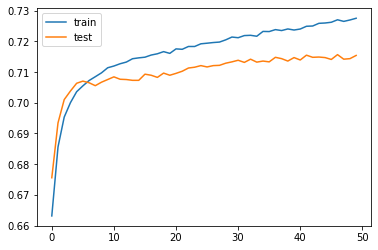

In [84]:
_, train_recall = model.evaluate(X_train, y_train, verbose=0)
_, val_recall = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_recall, val_recall))
# plot history
import matplotlib.pyplot as plt
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.legend()
plt.show()

After epoch 5/6, we see that our model starts to overfit, as train accuracy tends to increase, but test accuracy stays more or less on the same level. This can be seen by the divergence of the two curves. The neural network already is optimised, we tried it with more and less hidden layers, aand more and less neurons per layer, but this setup displayed here shows the best results.

<a id="pipeline"><a>
# 5. Building the full pipeline

In [66]:
df_model = pd.read_csv("completed_default.csv")

In [69]:
X = df_model.drop(['LoanStatus'], axis=1)
y = df_model['LoanStatus']

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id="logreg_th"><a>
## 5.1 Logistic Regression with Tuned Hyperparameters

In [33]:
from sklearn.pipeline import Pipeline

pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components_svd)),
    ('logreg', LogisticRegression(C=100, penalty='l1', solver='liblinear', class_weight='balanced'))
])

In [34]:
pipeline_logreg.fit(X_train, y_train)
pred_logreg = pipeline_logreg.predict(X_test)

In [31]:
from sklearn.metrics import roc_auc_score

In [36]:
recall_logreg = recall_score(y_test, pred_logreg)
accuracy_logreg = accuracy_score(y_test, pred_logreg)

auc_logreg = roc_auc_score(y_test, pred_logreg)

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_logreg))

              precision    recall  f1-score   support

           0       0.50      0.69      0.58      3799
           1       0.81      0.66      0.73      7674

    accuracy                           0.67     11473
   macro avg       0.66      0.68      0.66     11473
weighted avg       0.71      0.67      0.68     11473



<a id="rc_th"><a>
## 5.2 Ridge Classifier with Tuned Hyperparameters

In [38]:
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components_svd)),
    ('ridge', RidgeClassifier(class_weight = 'balanced', alpha=0.1, solver= 'sag'))
])

In [39]:
pipeline_ridge.fit(X_train, y_train)
pred_ridge = pipeline_ridge.predict(X_test)

In [40]:
recall_ridge = recall_score(y_test, pred_ridge)
accuracy_ridge = accuracy_score(y_test, pred_ridge)

auc_ridge = roc_auc_score(y_test, pred_ridge)

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_ridge))

              precision    recall  f1-score   support

           0       0.50      0.70      0.58      3799
           1       0.81      0.65      0.73      7674

    accuracy                           0.67     11473
   macro avg       0.66      0.68      0.65     11473
weighted avg       0.71      0.67      0.68     11473



<a id="knn_th"><a>
## 5.3 KNN with Tuned Hyperparameters

In [71]:
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(40)),
    ('ridge', KNeighborsClassifier(n_neighbors=13))
])

In [72]:
pipeline_knn.fit(X_train, y_train)
pred_knn = pipeline_knn.predict(X_test)

In [73]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [74]:
recall_knn = recall_score(y_test, pred_knn)
accuracy_knn = accuracy_score(y_test, pred_knn)

auc_knn = roc_auc_score(y_test, pred_knn)

In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44      3882
           1       0.72      0.86      0.78      7472

    accuracy                           0.69     11354
   macro avg       0.64      0.61      0.61     11354
weighted avg       0.67      0.69      0.67     11354



<a id="dt_th"><a>
## 5.4 Decision Tree with Tuned Hyperparameters 

In [64]:
pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components_svd)),
    ('tree', DecisionTreeClassifier(max_depth=30))
])

In [65]:
pipeline_tree.fit(X_train, y_train)
pred_tree = pipeline_tree.predict(X_test)

In [66]:
recall_tree = recall_score(y_test, pred_tree)
accuracy_tree = accuracy_score(y_test, pred_tree)

auc_tree = roc_auc_score(y_test, pred_tree)

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.43      0.45      0.44      3799
           1       0.72      0.71      0.72      7674

    accuracy                           0.62     11473
   macro avg       0.58      0.58      0.58     11473
weighted avg       0.63      0.62      0.62     11473



<a id="svc_th"><a>
## 5.5 SVC with Tuned Hyperparameters

In [50]:
pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', TruncatedSVD(n_components_svd)),
    ('svc', SVC(class_weight='balanced', C=1))
])

In [51]:
pipeline_svc.fit(X_train, y_train)
pred_svc = pipeline_svc.predict(X_test)

In [52]:
recall_svc = recall_score(y_test, pred_svc)
accuracy_svc = accuracy_score(y_test, pred_svc)

auc_svc = roc_auc_score(y_test, pred_svc)

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       0.50      0.72      0.59      3799
           1       0.83      0.65      0.73      7674

    accuracy                           0.67     11473
   macro avg       0.66      0.69      0.66     11473
weighted avg       0.72      0.67      0.68     11473



<a id="model_eval"><a>
# 6. Model Evaluation

In [68]:
logreg = [recall_logreg, accuracy_logreg, auc_logreg]
ridge = [recall_ridge, accuracy_ridge, auc_ridge]
knn = [recall_knn, accuracy_knn, auc_knn]
tree = [recall_tree, accuracy_tree, auc_tree]
svc = [recall_svc, accuracy_svc, auc_svc]

In [69]:
pd.DataFrame({'logreg': logreg, 'ridge': ridge, 'knn':knn, 'tree': tree, 'svc':svc}, index=['recall', 'accuracy', 'auc'])

,logreg,ridge,knn,tree,svc
recall,0.660021,0.654548,0.853922,0.710190,0.648293
accuracy,0.671577,0.668265,0.693454,0.623377,0.672884
auc,0.677470,0.675260,0.611615,0.579101,0.685426


As we can see, the fine-tuned KNN is the best-performing model. It presents the highest Recall (our target sucess metric), and, at the same time, the highest accuracy.

Depending on the context however, it may be interesting to use the DecisionTree Classifier here, as its results are quite good, as well, and, in contrast to other good-performing algorithms like the Neural Network and the SVC, the Decision Tree yields high interpretability. So, although results for other models are slightly better, we would tend to choose the Decision Tree in this business context. Working in a live environment, however, the decision tree may be not the best choice, as one of the problems is oversensitivity and stability, regarding new data points, and irrelevant attributes. This applies, if we wanted to retrain the model in the live setting, as changes near a root node would have a huge impact on the whole model, even though it might not be this relevant. On top of that, Decision Trees easily tend to overfit, which also appears to be the case in our model.

SVC, for example has the disadvantage, that it takes very long to compute. Logistic Regression, would need less computational power than SVC, for example, while having the highest AUC of all models, after SVC.

### Load the current loans to predict on them

Now comes the part where our model comes into places for the Solution of our Business Problem. We built a model that does a really good job in predicting the defaulted loans. 

Now we use this model to predict on the current loans, where whe don't know whether they will default or not, if they will default. To this end, we save and load the model as a pickle and predict on some selected loans whether they default.

In [78]:
df_production = pd.read_csv("csv_current.csv")

In [79]:
df_production['LoanStatus'].value_counts()

Current    56576
Name: LoanStatus, dtype: int64

As we can see, our production data set only countains current loans. Let's curate this data so that we can use it to predict its labels, using our trained model.

In [80]:
X_prod = df_production.drop(['LoanStatus'], axis=1)

In [ ]:
pred_prod = pipeline_knn.predict(X_prod)

In [119]:
pred_prod[1]

1

It seems like the record we try to predict has defaulted. Let's have a look at its chracteristics and try to explain the algorithm's prediction.

In [121]:
X_prod.loc[1]

Term                                                  36
BorrowerAPR                                      0.11194
BorrowerRate                                       0.105
LenderYield                                        0.105
EstimatedEffectiveYield                          0.08585
EstimatedLoss                                     0.0724
ProsperScore                                           6
ListingCategory                                    Other
BorrowerState                              StateHighRisk
Occupation                             OccupationMidRisk
EmploymentStatus                               Full-time
EmploymentStatusDuration                             126
IsBorrowerHomeowner                                    0
CurrentlyInGroup                                       0
CreditScore                                          800
CurrentCreditLines                                     4
OpenCreditLines                                        2
TotalCreditLinespast7years     

Turns out that this credit was about 24000 dollars, from a high-risk state. The borrower has not commited any crimes in the near past, but does not have a house and has a mid-risk full-time occupation. All in all, it seems plausible that the algorithm predicts a default on this record.

As we can see, our algorithm provides some really nice summary and estimation about the Prosper P2P Lending platform.

**If you wish to go back to the top of the Notebook [click here](#the_top)**